In [1]:
cd gamedata

/Users/benyeagley/Desktop/sp19-222-92/project/gamedata


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

# Used for normalization
from sklearn import preprocessing

# Used to shuffle data
import random

# Used to perform dimensionality reduction
from sklearn.decomposition import PCA

# Used for KMeans clustering
from sklearn.cluster import KMeans

In [3]:
# File name should probably be read in as an argument to a function
datafile = "total_game_data2.csv"

df = pd.read_csv(datafile)
df.head()

,Class,HR min [bpm],HR avg [bpm],HR max [bpm],HR min [%],HR avg [%],HR max [%],Time in HR zone 1 (50 - 59 %),Time in HR zone 2 (60 - 69 %),Time in HR zone 3 (70 - 79 %),...,Number of accelerations (-1.99 - -1.00 m/s),Number of accelerations (-0.99 - -0.50 m/s),Number of accelerations (0.50 - 0.99 m/s),Number of accelerations (1.00 - 1.99 m/s),Number of accelerations (2.00 - 2.99 m/s),Number of accelerations (3.00 - 50.00 m/s),Calories [kcal],Training load score,Recovery time [h],Min Played
0,Forward,37,148,210,19,74,105,0:19:22,0:27:11,0:56:50,...,399,762,593,389,119,19,1343,230,46.0,99
1,Midfielder,62,98,188,31,49,94,0:23:49,0:08:11,0:08:23,...,82,239,211,69,12,0,495,30,5.5,0
2,Forward,80,150,217,40,75,109,0:28:32,0:20:40,0:15:03,...,302,601,500,333,97,11,1407,289,135.7,82
3,Defender,86,150,200,43,75,100,0:19:42,0:15:29,0:19:19,...,352,590,647,360,77,12,1462,302,151.4,79
4,Defender,83,121,192,42,61,96,1:23:38,0:25:26,0:11:26,...,129,325,276,118,21,7,1019,118,21.3,7


In [4]:
# Removes every row where a player had zero minutes played
df = df[df['Min Played'] != 0]

#Reset index for df
df = df.reset_index(drop=True)

In [5]:
#Drop unnecessary columns (one line?)
df = df[df.columns.drop(list(df.filter(regex='Time')))]
df = df[df.columns.drop(list(df.filter(regex='HR')))]
df = df[df.columns.drop(list(df.filter(regex='Calories')))]
df = df[df.columns.drop(list(df.filter(regex='load score')))]
df = df[df.columns.drop(list(df.filter(regex='Recovery')))]
df = df[df.columns.drop(list(df.filter(regex='Speed zone 1')))]

# Shuffle the data
[m,n] = df.shape
df = df.sample(frac=1)

In [6]:
labels = df['Class']
df = df[df.columns.drop(list(df.filter(regex='Class')))]

#Reset index for df
df = df.reset_index(drop=True)

In [7]:
# Column names to use in later loop
distance_columns = ('Distance in Speed zone 2 [yd] (0.10 - 2.59 mph)', 'Distance in Speed zone 3 [yd] (2.60 - 5.13 mph)', 'Distance in Speed zone 4 [yd] (5.14 - 8.38 mph)', 'Distance in Speed zone 5 [yd] (8.39- mph)')
accel_columns = ('Number of accelerations (-50.00 - -3.00 m/s)', 'Number of accelerations (-2.99 - -2.00 m/s)', 'Number of accelerations (-1.99 - -1.00 m/s)', 'Number of accelerations (-0.99 - -0.50 m/s)', 'Number of accelerations (0.50 - 0.99 m/s)', 'Number of accelerations (1.00 - 1.99 m/s)', 'Number of accelerations (2.00 - 2.99 m/s)', 'Number of accelerations (3.00 - 50.00 m/s)')

# Create new column for total accelerations
df['Total accelerations'] = pd.Series(np.random.randn(len(df)), index=df.index)

# Convert column dtypes to floats for percentage values
df['Sprints'] = df['Sprints'].apply(np.float64)
for i in distance_columns:
    df[i] = df[i].apply(np.float64)
for i in accel_columns:
    df[i] = df[i].apply(np.float64)

# Adjust sprints for minutes played, adjust speed zones for total distance, and get total accelerations
for index, row in df.iterrows():
    # Initialize total acceleration value
    total_accels = 0
    # Change # of sprints to sprints per min
    df.at[index, 'Sprints'] = row['Sprints'] / row['Min Played']
    # Divide distance in speed zone by total distance, save back in speed zone column
    for i in distance_columns:
        df.at[index, i] = (row[i]) / int(row['Total distance [yd]'])
    # Calculate total # of accelerations and save in new column
    for i in accel_columns:
        total_accels += row[i]
    df.at[index, 'Total accelerations'] = total_accels

# Second loop to divide each acceleration column by the total accelerations, save back in acceleration columns
for index, row in df.iterrows():
    for i in accel_columns:
        df.at[index, i] = (row[i]) / int(row['Total accelerations'])

# Shows all remaining columns and whether they were dropped or not (tested to maximize scores at the end)
df = df[df.columns.drop(list(df.filter(regex='Total distance')))]
df = df[df.columns.drop(list(df.filter(regex='Distance / min')))]
df = df[df.columns.drop(list(df.filter(regex='Average')))]
df = df[df.columns.drop(list(df.filter(regex='Max')))]
df = df[df.columns.drop(list(df.filter(regex='Sprints')))]
#df = df[df.columns.drop(list(df.filter(regex='zone 2')))]
#df = df[df.columns.drop(list(df.filter(regex='zone 3')))]
df = df[df.columns.drop(list(df.filter(regex='zone 4')))]
#df = df[df.columns.drop(list(df.filter(regex='zone 5')))]
#df = df[df.columns.drop(list(df.filter(regex='-50.00 - -3.00')))]
#df = df[df.columns.drop(list(df.filter(regex='-2.99 - -2.00')))]
#df = df[df.columns.drop(list(df.filter(regex='-1.99 - -1.00')))] ####
df = df[df.columns.drop(list(df.filter(regex='-0.99 - -0.50')))]
df = df[df.columns.drop(list(df.filter(regex='0.50 - 0.99')))]
#df = df[df.columns.drop(list(df.filter(regex='1.00 - 1.99')))] 
#df = df[df.columns.drop(list(df.filter(regex='2.00 - 2.99')))] 
#df = df[df.columns.drop(list(df.filter(regex='3.00 - 50.00')))]
df = df[df.columns.drop(list(df.filter(regex='Min Played')))]
df = df[df.columns.drop(list(df.filter(regex='Total accelerations')))]

df.head()

,Distance in Speed zone 2 [yd] (0.10 - 2.59 mph),Distance in Speed zone 3 [yd] (2.60 - 5.13 mph),Distance in Speed zone 5 [yd] (8.39- mph),Number of accelerations (-50.00 - -3.00 m/s),Number of accelerations (-2.99 - -2.00 m/s),Number of accelerations (-1.99 - -1.00 m/s),Number of accelerations (1.00 - 1.99 m/s),Number of accelerations (2.00 - 2.99 m/s),Number of accelerations (3.00 - 50.00 m/s)
0,0.166138,0.314392,0.215767,0.014085,0.039003,0.157096,0.158722,0.035211,0.008667
1,0.128596,0.267475,0.230156,0.009404,0.038662,0.162487,0.150470,0.038662,0.003135
2,0.138226,0.257258,0.211452,0.009756,0.047154,0.153659,0.165041,0.039024,0.006504
3,0.324419,0.315891,0.095736,0.002037,0.024440,0.126273,0.122200,0.026477,0.001018
4,0.171529,0.319098,0.179422,0.006222,0.035633,0.166855,0.155543,0.039593,0.006222


In [8]:
# Normalize

x = df.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)

# Test effects of weighing certain columns
#df[column] = df[column]apply(lambda x: x*weight)

# Save changes in new csv to view later
df.to_csv("altered_total.csv")

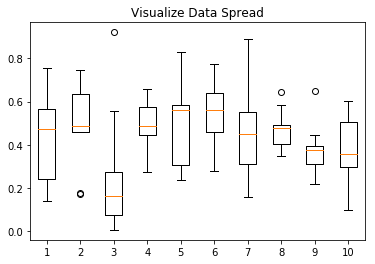

In [9]:
# Box plots for data columns
fig7, ax7 = plt.subplots()
ax7.set_title('Visualize Data Spread')
_ = ax7.boxplot(df[1:11])

In [10]:
# Reduce to two dimensions (uses data from every column, are they all really needed / does this overfit???)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

# Add the labels back to the df
finalDf = pd.concat([principalDf, labels], axis = 1)

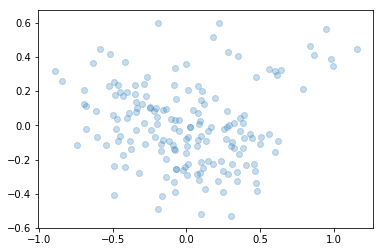

In [11]:
# Store dimensions of dataframe and convert to an array
[m,n] = finalDf.shape
df_array = finalDf.values

# Columns to be used for clustering
ind1 = 0; ind2 = 1

X = np.zeros((m,2))
X[:,0] = df_array[:,ind1]
X[:,1] = df_array[:,ind2]

_ = plt.scatter( X[:,0],X[:,1], alpha=0.25 )

In [12]:
def shape_assign(labels):
    shape_labels = []
    for i in labels:
        if(i == 'Forward'):
            shape_labels.append('x')
        elif(i == 'Midfielder'):
            shape_labels.append('^')
        elif(i == 'Defender'):
            shape_labels.append('.')
    return shape_labels

markers = shape_assign(labels)

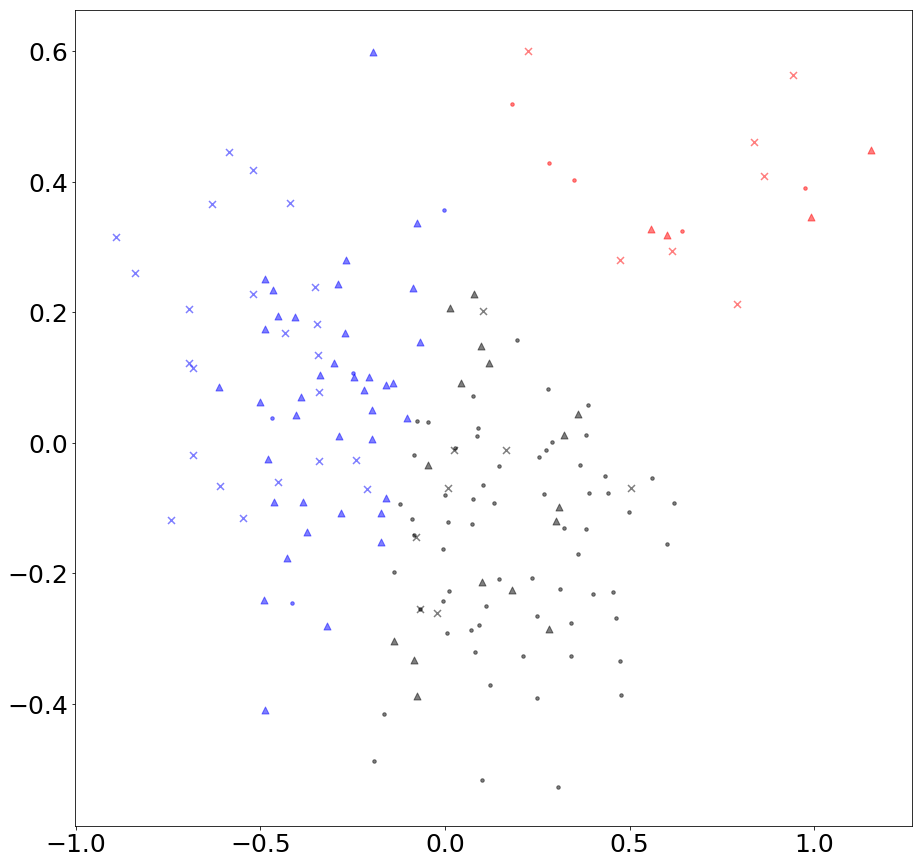

In [13]:
# Scatter plot customization
plt.rcParams['figure.figsize'] = (15,15) 
plt.rcParams['font.size'] = 25 
plt.rcParams['lines.markersize'] = 7

# KMeans clustering code
kmeans = KMeans( n_clusters=3 ).fit(X)
x = X[:,0]
y = X[:,1]

# Function that lists color values for identifying the kmeans clusters
def assign_color(labels):
    colors = []
    for i in labels:
        if i == 0:
            colors.append('r')
        elif i == 1:
            colors.append('b')
        elif i == 2:
            colors.append('k')
    return colors

# Call function on kmeans labels
col = assign_color(kmeans.labels_)

# Plot each point one by one 
for i in range(len(X)):
    plt.scatter(x[i], y[i], c=col[i], marker=markers[i], alpha=0.5)
    
plt.savefig('cluster_plot.png')

In [14]:
# Function to convert class to a numeric value - 0, 1, or 2
def labels_to_numeric(labels, x, y, z):
    numeric_labels = []
    for i in labels:
        if i == 'Forward':
            numeric_labels.append(x)
        elif i == 'Midfielder':
            numeric_labels.append(y)
        else:
            numeric_labels.append(z)
    return(numeric_labels)

# Convert labels to numeric value
numeric_labels = labels_to_numeric(labels, 0, 1, 2)

from sklearn.metrics.cluster import v_measure_score, completeness_score, homogeneity_score
print("Homogeneity: %0.3f" % homogeneity_score(numeric_labels, kmeans.labels_))
print("Completeness: %0.3f" % completeness_score(numeric_labels, kmeans.labels_))
print("V-measure: %0.3f" % v_measure_score(numeric_labels, kmeans.labels_))

Homogeneity: 0.227
Completeness: 0.260
V-measure: 0.242


In [15]:
X = df
Y = labels

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=0)

In [16]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs')
logreg.fit(X_train, y_train)
print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(logreg.score(X_train, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(logreg.score(X_test, y_test)))

Accuracy of Logistic regression classifier on training set: 0.64
Accuracy of Logistic regression classifier on test set: 0.65


In [17]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=3).fit(X_train, y_train)
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of Decision Tree classifier on training set: 0.76
Accuracy of Decision Tree classifier on test set: 0.65


In [18]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(X_train, y_train)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of K-NN classifier on training set: 0.74
Accuracy of K-NN classifier on test set: 0.74


In [19]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=2)
lda.fit(X_train, y_train)
print('Accuracy of LDA classifier on training set: {:.2f}'
     .format(lda.score(X_train, y_train)))
print('Accuracy of LDA classifier on test set: {:.2f}'
     .format(lda.score(X_test, y_test)))

Accuracy of LDA classifier on training set: 0.69
Accuracy of LDA classifier on test set: 0.63


In [20]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
print('Accuracy of GNB classifier on training set: {:.2f}'
     .format(gnb.score(X_train, y_train)))
print('Accuracy of GNB classifier on test set: {:.2f}'
     .format(gnb.score(X_test, y_test)))

Accuracy of GNB classifier on training set: 0.70
Accuracy of GNB classifier on test set: 0.74


In [21]:
from sklearn.svm import SVC
svm = SVC()
svm.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svm.score(X_test, y_test)))

Accuracy of SVM classifier on training set: 0.62
Accuracy of SVM classifier on test set: 0.65
